# Calculate Distance Between Chapters of Augustine's _Confessions_

This notebook adapts the workflow used by Andrew Piper in _Enumerations: Data and Literary Study_ (Chicago, 2018) for Python and Scikit-learn. It uses NLTK to preprocess the input files and cuts the input dataset down to 479 tokens, scales the values based complete token length, calculates Euclidean distances, and represents in two-dimensional space using MDS.

In [1]:
import nltk
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import euclidean_distances

In [2]:
latin_stopwords = ["a", "ab", "ac", "ad", "adhic ", "aliqui", "aliquis", 
           "an", "ante", "apud", "at", "atque", "aut", "autem", 
           "cum", "cur", "de", "deinde", "dum", "ego", "enim", 
           "ergo", "es", "est", "et", "etiam", "etsi", "ex", 
           "fio", "haud", "hic", "iam", "idem", "igitur", "ille", 
           "in", "infra", "inter", "interim", "ipse", "is", "ita",
           "magis", "modo", "mox", "nam", "ne", "nec", "necque", 
           "neque", "nisi", "non", "nos", "o", "ob", "per", "possum", 
           "post", "pro", "quae", "quam", "quare", "qui", "quia", 
           "quicumque", "quidem", "quilibet", "quis", "quisnam", 
           "quisquam", "quisque", "quisquis", "quo", "quoniam", 
           "sed", "si", "sic", "sive", "sub", "sui", "sum", 
           "super", "suus", "tam", "tamen", "trans", "tu", 
           "tum", "ubi", "uel", "uero"]

In [3]:
def remove_digits(input_document):

    # CountVectorizer operates on entire document
    tokens = nltk.word_tokenize(input_document)
    tmp_text=list()

    # for each word
    for word in tokens:
        
        # drop to lowercase
        word = word.lower()
        # takes care of one character non-alpha words
        if len(word) == 1 :
            if word.isalpha() == True:
                tmp_text.append(word)
        else:
            # else append only if not a digit
            # check for periods and commas
            word = word.replace('.','')
            word = word.replace(',','')
            if word.isdigit() == False:
                tmp_text.append(word)
                
    output_object = ' '.join(tmp_text)
    return output_object

In [4]:
texts=["AugustineLatinChapter/1",
       "AugustineLatinChapter/2",
       "AugustineLatinChapter/3",
       "AugustineLatinChapter/4",
       "AugustineLatinChapter/5",
       "AugustineLatinChapter/6",
       "AugustineLatinChapter/7",
       "AugustineLatinChapter/8", 
       "AugustineLatinChapter/9", 
       "AugustineLatinChapter/10", 
       "AugustineLatinChapter/11", 
       "AugustineLatinChapter/12",
       "AugustineLatinChapter/13"]


# first obtain total token with all the stopwords.
# we are doing this in order to scale the token counts
vectorizer_totals = CountVectorizer(input='filename',
                                    preprocessor=remove_digits,
                                    strip_accents='unicode',lowercase=True)
dtm_total_matrix = vectorizer_totals.fit_transform(texts)


# Piper used sparsity of .4  = 60% of documents
df_factor = int(np.round((len(texts)*.6),0))

# Note that a custom processor will override lowercase removal
# we need a custom preprocess for CountVectorizer because we need 
# to remove the digits/numbers (stop_words functions as expected)
vectorizer = CountVectorizer(input='filename',
                             stop_words=latin_stopwords,
                             strip_accents='unicode',lowercase=True,
                             preprocessor=remove_digits,
                             min_df=df_factor)

dtm_matrix = vectorizer.fit_transform(texts).toarray()

In [5]:
# now scale the values
scaling = np.sum(dtm_total_matrix,axis=1)
dtm_matrix = dtm_matrix / scaling

In [6]:
# tell us about the model
documents, vocabulary = dtm_matrix.shape
print("Documents:",documents)
print("Vocabulary:",vocabulary)

Documents: 13
Vocabulary: 479


In [7]:
# calculate Euclidean distances between each text
dist_matrix = euclidean_distances(dtm_matrix)

In [8]:
# display distance from the first text
from operator import itemgetter
for x,y in sorted(enumerate(np.round(dist_matrix[0],3)), key=itemgetter(1)):
    print("{0:.3f} {1}".format(y, texts[x]))

0.000 AugustineLatinChapter/1
0.017 AugustineLatinChapter/4
0.018 AugustineLatinChapter/2
0.018 AugustineLatinChapter/5
0.018 AugustineLatinChapter/10
0.020 AugustineLatinChapter/8
0.020 AugustineLatinChapter/9
0.021 AugustineLatinChapter/3
0.023 AugustineLatinChapter/6
0.023 AugustineLatinChapter/7
0.024 AugustineLatinChapter/13
0.028 AugustineLatinChapter/12
0.029 AugustineLatinChapter/11


In [9]:
# reduce using MDS (n_components=2 is the default--we want just two dimensions)
from sklearn.manifold import MDS
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist_matrix)

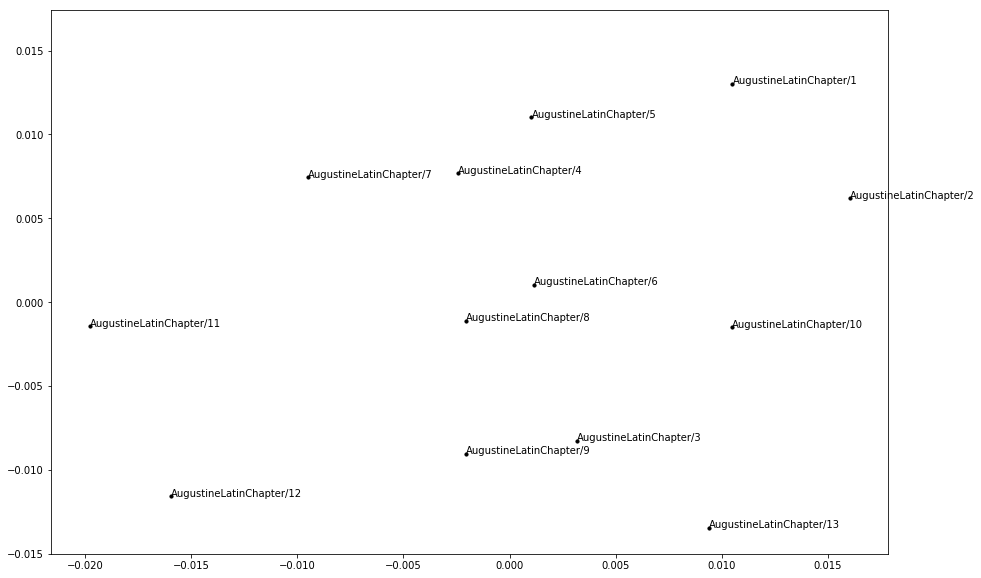

In [10]:
# plot!
import matplotlib.pyplot as plt
xs, ys = pos[:, 0], pos[:, 1]
fig = plt.figure(figsize=(15, 10),)

for x, y, text in zip(xs, ys, texts):
    plt.scatter(x, y, c='black',s=10)
    plt.text(x, y, text)
plt.show()